In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import ml_metrics as metrics

# Подготовка и анализ данных

In [2]:
#load data
data = pd.read_csv("E:\GitHub\MasterWork\Data\S&P 500 Historical Data00-20.csv")

In [3]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.set_index('Date')
data.Price = data.Price.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data["Vol."] = data["Vol."].astype(float)

In [4]:
temp_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2014-01-01')]
temp_data.set_index('Date', inplace=True)
price = temp_data.Price

<AxesSubplot: xlabel='Date'>

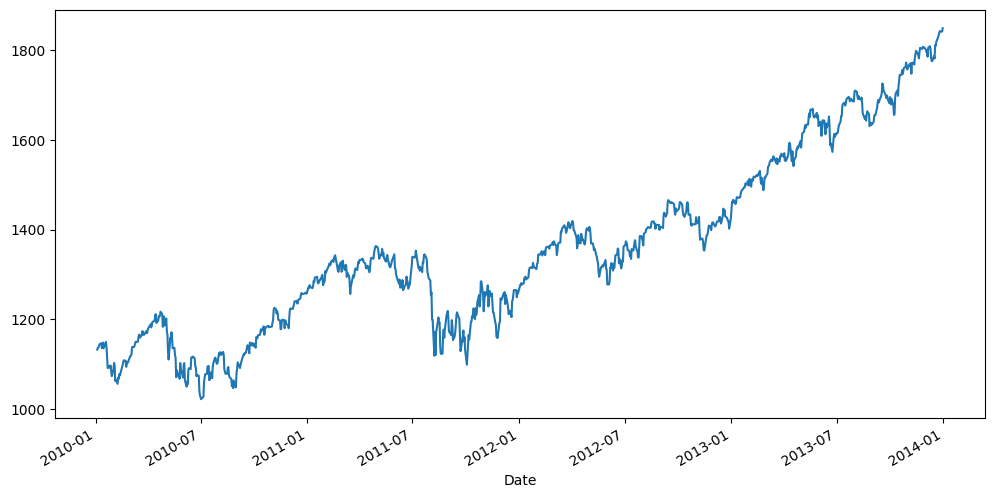

In [5]:
price.plot(figsize=(12,6))

<AxesSubplot: >

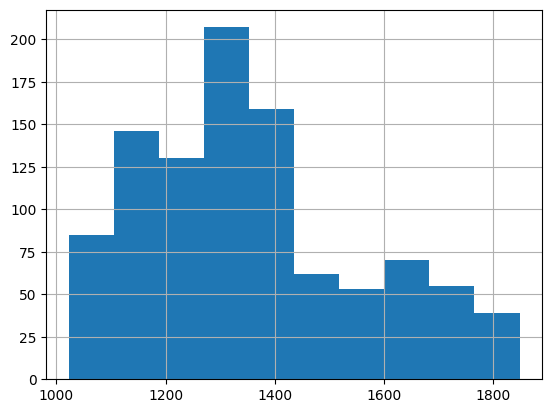

In [6]:
price.hist()

In [7]:
# max, min, mean, median, quantile 1 and 3, std, var(std/mean)
price_max = temp_data.Price.max()
price_min = temp_data.Price.min()
price_mean = temp_data.Price.median()
price_quant = temp_data.Price.quantile()
price_std = temp_data.Price.std()
price_var = price_std / price_mean

In [8]:
temp_data.Price.describe(include='all')

count    1006.000000
mean     1357.646093
std       198.308586
min      1022.580000
25%      1197.772500
50%      1328.215000
75%      1461.155000
max      1848.360000
Name: Price, dtype: float64

In [9]:
price_var

0.14930458261444363

In [10]:
# Вариация меньше 30%, так что можем работать с этими данными
# Проведем тест Харки — Бера для определения номарльности распределения
row = [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(price)
a = np.vstack([jb_test])
result = SimpleTable(a, row)

In [11]:
result

JB,p-value,skew,kurtosis
66.06986479758675,4.498949819595846e-15,0.5709891752348574,2.4783632628260492


In [12]:
# Проверим значения на стационарность проведя обобщённый тест Дикки-Фуллера
test = sm.tsa.adfuller(price)
print('adf: ', test[0] )
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  0.502474321545715
p-value:  0.9849481076057242
Critical values:  {'1%': -3.4369061654329998, '5%': -2.86443457404, '10%': -2.568311209}
есть единичные корни, ряд не стационарен


In [13]:
price_diff_1 = price.diff(periods = 1).dropna()
test = sm.tsa.adfuller(price_diff_1)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -16.212887527064936
p-value:  3.9696372946255213e-29
Critical values:  {'1%': -3.4369061654329998, '5%': -2.86443457404, '10%': -2.568311209}
единичных корней нет, ряд стационарен


In [14]:
# Получившийся ряд первых разностей приблизился к стационарному
# Для полной уверенности разобъем его на несколько промежутков и убедимся мат. ожидания на разных интервалах
m = price_diff_1.index[int(len(price_diff_1.index)/2)+1]
r1 = sm.stats.DescrStatsW(price_diff_1[m:])
r2 = sm.stats.DescrStatsW(price_diff_1[:m])
print('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.29541513458889324


In [15]:
# Высокое p-value дает нам возможность утверждать, что нулевая гипотеза о равенстве средних верна, что свидетельствует о стационарности ряда.

<AxesSubplot: xlabel='Date'>

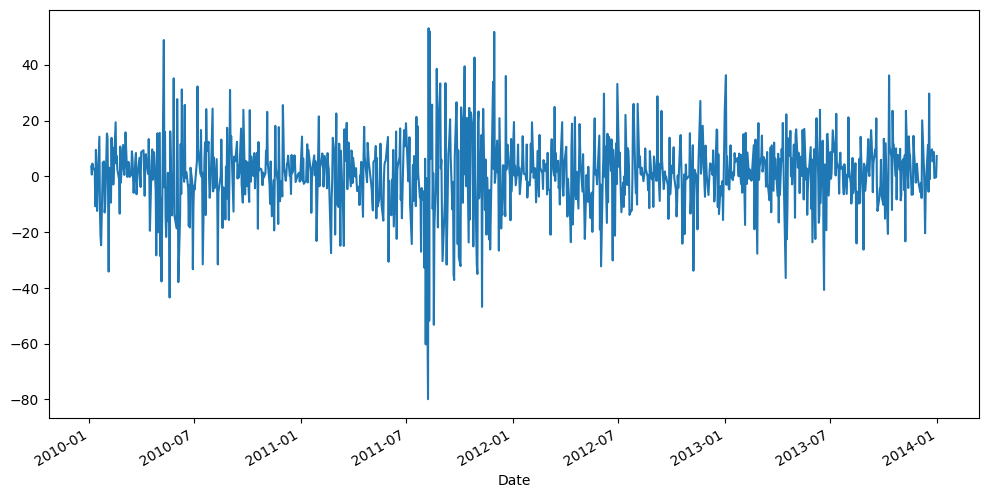

In [16]:
# Убедимся в отсутствие тренда
price_diff_1.plot(figsize=(12,6))

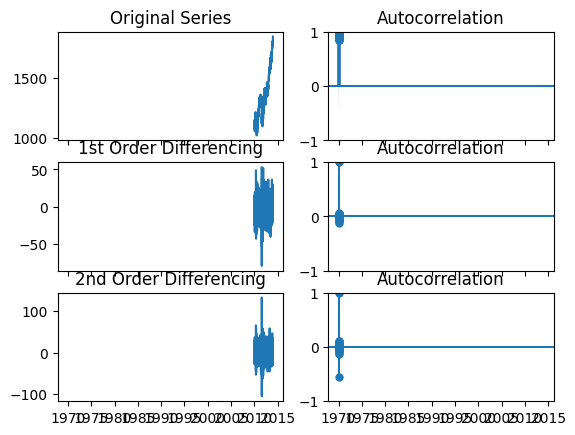

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(price); axes[0, 0].set_title('Original Series')
plot_acf(price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(price.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(price.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(price.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(price.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

# Построение модели ARIMA

Для построение модели нам нужно знать 3 параметра:

p — порядок компоненты AR

d — порядок интегрированного ряда

q — порядок компонетны MA

Порядок интегрирования был вычислен во время подготовки данных.

C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


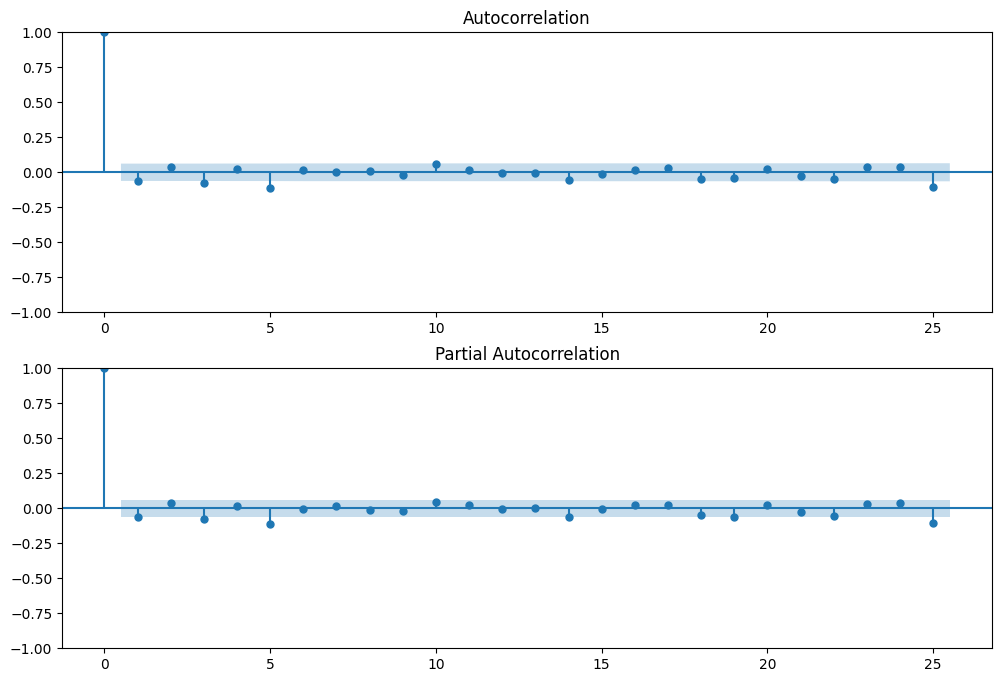

In [18]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(price_diff_1.values.squeeze(), lags = 25, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(price_diff_1, lags = 25, ax = ax2)

In [19]:
# Вообще нужно поправить ряд и удалять те наблюдения, которые слишком выпадают
# После изучения коррелограммы PACF можно сделать вывод, что p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля. 
# По коррелограмме ACF можно увидеть, что q = 1, т.к. после лага 1 значении функций резко падают.
price.index = price.index.to_period('D')
model = sm.tsa.ARIMA(price[:'2013-01-01'], order=(1,1,1)).fit()

C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Skiv2\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [20]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  754
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3056.808
Date:                Fri, 11 Nov 2022   AIC                           6119.617
Time:                        17:12:21   BIC                           6133.489
Sample:                    01-04-2010   HQIC                          6124.961
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8337      0.075    -11.152      0.000      -0.980      -0.687
ma.L1          0.7650      0.088      8.648      0.000       0.592       0.938
sigma2       196.5922      7.155     27.475      0.0

In [21]:
# Проведем Q-тест Льюнга — Бокса для проверки гипотезы о том, что остатки случайны
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) # свойство resid, хранит остатки модели, qstat = True, означает что применяем указынный тест к коэф-ам
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

      Q-stat   p-value
0   0.014173  0.905234
1   0.015211  0.992423
2   0.016167  0.999456
3   0.016498  0.999966
4   0.069111  0.999935
5   0.177018  0.999892
6   0.234861  0.999956
7   0.234949  0.999993
8   0.320009  0.999996
9   0.550620  0.999990
10  0.574603  0.999997
11  0.833152  0.999995
12  1.095742  0.999993
13  1.109541  0.999998
14  1.118304  0.999999
15  1.128650  1.000000
16  1.150885  1.000000
17  1.378280  1.000000
18  1.424469  1.000000
19  1.600220  1.000000
20  1.641905  1.000000
21  2.532940  1.000000
22  2.551252  1.000000
23  2.555219  1.000000
24  2.565159  1.000000
25  2.595436  1.000000
26  2.702017  1.000000
27  2.709084  1.000000


In [22]:
pred = model.predict('2013-01-01','2014-01-01', typ='levels')
trn = price['2013-01-01':]
r2 = r2_score(trn, pred[0:252]) # некорректное сравнение(дни в pred не совпадают с днями в trn)
print('R^2: %1.2f' % r2)

R^2: -4.90


<AxesSubplot: >

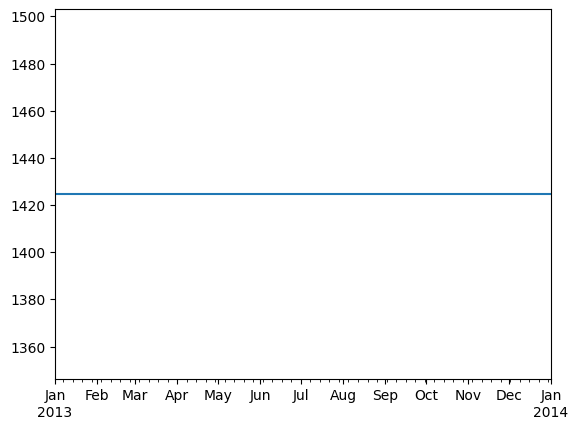

In [23]:
pred.plot()

In [24]:
# Среднеквадратичное отклонение модели
metrics.rmse(trn,pred[0:252]) # некорректное сравнение(дни в pred не совпадают с днями в trn)

240.57516683909355

In [25]:
# Средняя абсолютная ошибка прогноза
metrics.mae(trn,pred[0:252]) # некорректное сравнение(дни в pred не совпадают с днями в trn)

219.24388634561407

<AxesSubplot: xlabel='Date'>

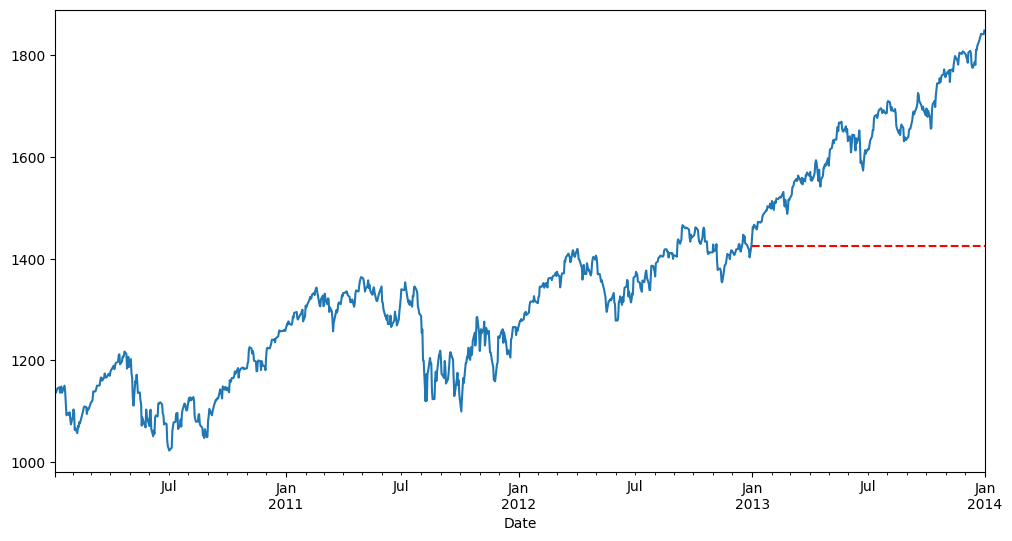

In [26]:
price.plot(figsize=(12,6))
pred.plot(style='r--')